In [1]:
import os
import keras

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y  

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [====

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 110us/step - loss: 2.0297 - accuracy: 0.2744 - val_loss: 1.8654 - val_accuracy: 0.3481
Epoch 2/20
50000/50000 [==============================] - 5s 107us/step - loss: 1.8017 - accuracy: 0.3701 - val_loss: 1.7456 - val_accuracy: 0.3899
Epoch 3/20
50000/50000 [==============================] - 5s 109us/step - loss: 1.7172 - accuracy: 0.3998 - val_loss: 1.6821 - val_accuracy: 0.4138
Epoch 4/20
50000/50000 [==============================] - 5s 106us/step - loss: 1.6599 - accuracy: 0.4192 - val_loss: 1.6359 - val_accuracy: 0.4286
Epoch 5/20
50000/50000 [==============================] - 5s 106us/step - loss: 1.6136 - accuracy: 0.4348 - val_loss: 1.5903 - val_accuracy: 0.4426
Epoch 6/20
50000/50000 [==============================] - 5s 105us/step - loss: 1.5739 - accuracy: 0.4500 - val_loss: 1.5629 - val_accuracy: 0.4504
Epoch 7/20
50000/50000 [==============================] - 5s 1

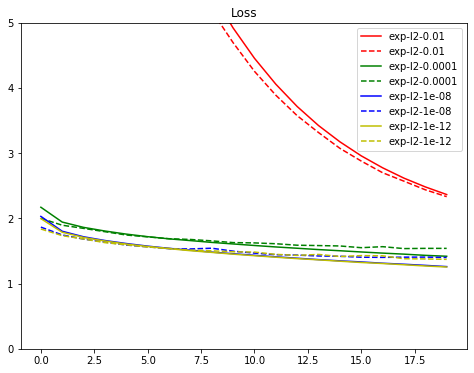

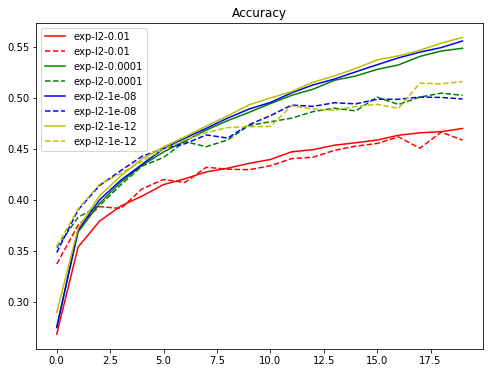

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [15]:
import itertools

In [16]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/500

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 116us/step - loss: 198.8598 - accuracy: 0.2407 - val_loss: 41.2352 - val_accuracy: 0.2832
Epoch 2/10
50000/50000 [==============================] - 6s 116us/step - loss: 19.1540 - accuracy: 0.1214 - val_loss: 7.2767 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 6s 112us/step - loss: 4.1030 - accuracy: 0.1000 - val_loss: 2.6512 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 6s 111us/step - loss: 2.4871 - accuracy: 0.0976 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 6s 111us/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 6s 113us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==============================] - 

50000/50000 [==============================] - 6s 114us/step - loss: 5.6907 - accuracy: 0.3986 - val_loss: 5.6296 - val_accuracy: 0.4018
Epoch 4/10
50000/50000 [==============================] - 6s 113us/step - loss: 5.5654 - accuracy: 0.4172 - val_loss: 5.5066 - val_accuracy: 0.4216
Epoch 5/10
50000/50000 [==============================] - 6s 115us/step - loss: 5.4526 - accuracy: 0.4305 - val_loss: 5.4173 - val_accuracy: 0.4342
Epoch 6/10
50000/50000 [==============================] - 6s 129us/step - loss: 5.3478 - accuracy: 0.4436 - val_loss: 5.3090 - val_accuracy: 0.4428
Epoch 7/10
50000/50000 [==============================] - 7s 134us/step - loss: 5.2482 - accuracy: 0.4567 - val_loss: 5.2264 - val_accuracy: 0.4487
Epoch 8/10
50000/50000 [==============================] - 6s 124us/step - loss: 5.1532 - accuracy: 0.4670 - val_loss: 5.1217 - val_accuracy: 0.4627
Epoch 9/10
50000/50000 [==============================] - 6s 124us/step - loss: 5.0634 - accuracy: 0.4730 - val_loss: 5.075

Epoch 6/10
50000/50000 [==============================] - 6s 110us/step - loss: 5.2408 - accuracy: 0.4423 - val_loss: 5.2226 - val_accuracy: 0.4362
Epoch 7/10
50000/50000 [==============================] - 5s 106us/step - loss: 5.1485 - accuracy: 0.4525 - val_loss: 5.1165 - val_accuracy: 0.4511
Epoch 8/10
50000/50000 [==============================] - 5s 108us/step - loss: 5.0582 - accuracy: 0.4612 - val_loss: 5.0311 - val_accuracy: 0.4582
Epoch 9/10
50000/50000 [==============================] - 5s 106us/step - loss: 4.9709 - accuracy: 0.4708 - val_loss: 4.9482 - val_accuracy: 0.4666
Epoch 10/10
50000/50000 [==============================] - 5s 105us/step - loss: 4.8879 - accuracy: 0.4798 - val_loss: 4.8882 - val_accuracy: 0.4638
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

Epoch 9/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.4840 - accuracy: 0.4781 - val_loss: 1.4961 - val_accuracy: 0.4695
Epoch 10/10
50000/50000 [==============================] - 6s 114us/step - loss: 1.4583 - accuracy: 0.4902 - val_loss: 1.4846 - val_accuracy: 0.4776
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 117us/step - loss: 2.1659 - accuracy: 0.2724 - val_loss: 2.0002 - val_accuracy: 0.3378
Epoch 2/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.9483 - accuracy: 0.3644 - val_loss: 1.8967 - val_accuracy: 0.3851
Epoch 3/10
50000/50000 [==============================] - 5s 110us/step - loss: 1.8649 - accuracy: 0.3972 - val_loss: 1.8296 - val_accuracy: 0.4116
Epoch 4/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.8088 - accuracy: 0.4167 - val_loss: 1.7838 - val_accuracy: 0.4258
Epoch 5/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.7633 - accuracy: 0.4322 - val_loss: 1.7492 - val_accuracy: 0.4346
Epoch 6/10
50000/50000 [==============================] - 6s 112us/step - loss: 1.7245 - accuracy: 0.4470 - val_loss: 1.7209 - val_accuracy: 0.4441
Epoch 7/10
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 114us/step - loss: 1.7214 - accuracy: 0.3960 - val_loss: 1.6842 - val_accuracy: 0.4085
Epoch 4/10
50000/50000 [==============================] - 5s 108us/step - loss: 1.6634 - accuracy: 0.4144 - val_loss: 1.6405 - val_accuracy: 0.4259
Epoch 5/10
50000/50000 [==============================] - 5s 106us/step - loss: 1.6159 - accuracy: 0.4334 - val_loss: 1.6073 - val_accuracy: 0.4398
Epoch 6/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.5771 - accuracy: 0.4486 - val_loss: 1.5701 - val_accuracy: 0.4507
Epoch 7/10
50000/50000 [==============================] - 5s 106us/step - loss: 1.5436 - accuracy: 0.4574 - val_loss: 1.5636 - val_accuracy: 0.4482
Epoch 8/10
50000/50000 [==============================] - 5s 108us/step - loss: 1.5131 - accuracy: 0.4691 - val_loss: 1.5201 - val_accuracy: 0.4624
Epoch 9/10
50000/50000 [==============================] - 5s 106us/step - loss: 1.4863 - accuracy: 0.4774 - val_loss: 1.503

Epoch 6/10
50000/50000 [==============================] - 5s 105us/step - loss: 1.5724 - accuracy: 0.4495 - val_loss: 1.5682 - val_accuracy: 0.4472
Epoch 7/10
50000/50000 [==============================] - 5s 105us/step - loss: 1.5377 - accuracy: 0.4624 - val_loss: 1.5400 - val_accuracy: 0.4545
Epoch 8/10
50000/50000 [==============================] - 5s 108us/step - loss: 1.5064 - accuracy: 0.4741 - val_loss: 1.5215 - val_accuracy: 0.4671
Epoch 9/10
50000/50000 [==============================] - 7s 132us/step - loss: 1.4804 - accuracy: 0.4835 - val_loss: 1.5211 - val_accuracy: 0.4648
Epoch 10/10
50000/50000 [==============================] - 6s 113us/step - loss: 1.4552 - accuracy: 0.4908 - val_loss: 1.4904 - val_accuracy: 0.4745
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         

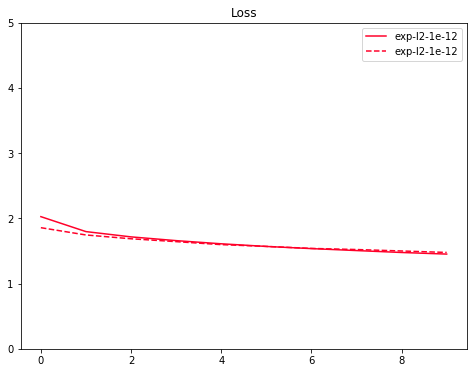

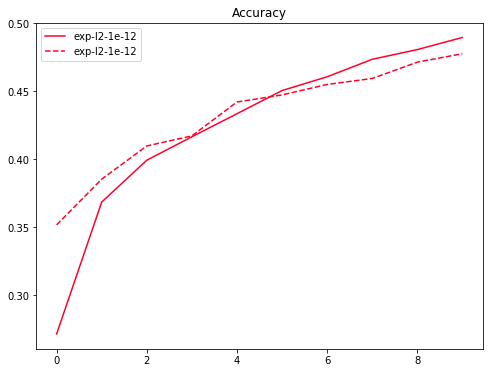

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()